<a href="https://colab.research.google.com/github/machiguchi-masaki/pokeca/blob/main/decklist_ver0_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

#seleniumインストール＆ライブラリ
!pip install selenium
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

from selenium import webdriver
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

from google.colab import drive
from bs4 import BeautifulSoup
import requests
import pandas as pd
from IPython.display import Image,display_jpeg
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.display import clear_output

clear_output()

In [3]:
# 初期設定値及び、googledriveのマウント
from google.colab import drive
drive.mount('/content/drive')

#デッキコード
deckcode = 'kVbFFF-EEDGwz-FFkvVv'

#作業フォルダ名(gogleドライブ/Mydrive/Pokemon/の下に作業フォルダを作成)
dir_name = '白馬チラチーノ'

#ファイル名
list_name ="list.csv" #同じカードまとめた
raw_name  ="raw.csv"  #同じカードまとめてない
#firsthands_n.csv n回の初手7+1ドロー
#firstsides_n.csv n回のサイド
#firstdecks_n.csv n回のデッキに残っているカード

#シュミレーション回数
loop=1000

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
##条件分岐対象##
#種ポケモン
basic_pokemons=['はくばバドレックスV','チラーミィ','デデンネGX','ミュウ']
#最初に並べたいポケモン
start_pokemons=['はくばバドレックスV']
start_pokemon_balls=['クイックボール','ポケモン通信']
#エネルギー
energies=['基本水エネルギー','たっぷりバケツ']
#アシストポケモン
assist_pokemons=['チラーミィ']
assist_pokemon_balls=['クイックボール','ポケモン通信','レベルボール']
#ドロサポ
supports=['博士の研究（マグノリア博士）','マリィ']
##デデクロ
dedekuros=['デデンネGX']
#まとめる
conditions=[basic_pokemons,start_pokemons,start_pokemon_balls,energies,assist_pokemons,assist_pokemon_balls,supports,dedekuros]

In [5]:
#作業ディレクトリ作成
tooldir = "/content/drive/MyDrive/pokemon/"
!mkdir -v $tooldir
workdir = "/content/drive/MyDrive/pokemon/" + dir_name
!mkdir -v $workdir
imagedir = workdir + "/image" 
!mkdir -v $imagedir

mkdir: cannot create directory ‘/content/drive/MyDrive/pokemon/’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/pokemon/白馬チラチーノ’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/pokemon/白馬チラチーノ/image’: File exists


In [6]:
#スクレイピング
d = webdriver.Chrome('chromedriver',options=options)
url ="https://www.pokemon-card.com/deck/confirm.html?viewMode=image&deckID="+deckcode
d.get(url)
soup = BeautifulSoup(d.page_source, 'html.parser')

imgBlocks = soup.select('.imgBlockArea')
cPoss = soup.select("[class='cPos nowrap']") 

for (imgBlock,cPos) in zip (imgBlocks,cPoss):
    #print(cPos.text)
    id   = imgBlock.img['id'].strip("img_")
    name = imgBlock.img['alt']
    num  = cPos.text.strip('枚')
    #print(id)
    #print(name)
    #print(num)

In [7]:
# デッキリスト及び画像を保存する

# list_name(デッキリスト)の出力
df_list = pd.DataFrame([],columns=['id','name','num'])
filename = workdir + "/" +list_name
for (imgBlock,cPos) in zip (imgBlocks,cPoss):
    id   = imgBlock.img['id'].strip("img_")
    name = imgBlock.img['alt']
    num  = cPos.text.strip('枚')
    df_list = df_list.append({'id':id,'name':name,'num':num},ignore_index=True)
df_list.to_csv(filename, index=False)
print(filename + "を保存しました")

#デッキリストに入っていないカードを条件に設定していないか
for condition in conditions:
  for item in condition:
    if (item in df_list.values):
      pass
    else:
      print(item+'はデッキに入っていません')
      raise ValueError(item+'はデッキに入っていません')

# raw_name(同じカードをまとめてないリスト)の出力
df_list = pd.read_csv(filename)
df_raw = pd.DataFrame([],columns=['id','name'])
filename = workdir + "/" +raw_name
for row, item in df_list.iterrows():
  for i in range(item['num']):
    df_raw = df_raw.append({'id':item['id'],'name':item['name']},ignore_index=True)
df_raw.to_csv(filename, index=False)
print(filename + "を保存しました")

# カード画像を保存する
for imgBlock in imgBlocks:
  id   = imgBlock.img['id'].strip("img_")   
  img_url = 'https://www.pokemon-card.com/' + imgBlock.img['src']
  r = requests.get(img_url)
  filename = workdir+'/image/' + id +'.jpg'
  with open(filename,'wb') as file:
    file.write(r.content)
    

/content/drive/MyDrive/pokemon/白馬チラチーノ/list.csvを保存しました
/content/drive/MyDrive/pokemon/白馬チラチーノ/raw.csvを保存しました


In [8]:
#関数

#引き直しチェック
def basic_pokemon_check(df_hands):
  result = False
  for basic_pokemon in basic_pokemons:
    if (basic_pokemon in df_hands.values):
      result = True
  return result


In [9]:
#n回シュミレーション
df_deck = df_raw
df_firsthands_id = pd.DataFrame([])
df_firsthands_name = pd.DataFrame([])
df_side_id = pd.DataFrame([])
df_side_name = pd.DataFrame([])
df_deck_id = pd.DataFrame([])
df_deck_name = pd.DataFrame([])
count_hikinaoshi = 0
for i in range(loop):
  #初期化
  df_deck = df_raw
  #初手の7枚を抽出し、ソートする
  while True:
    df_first = df_deck.sample(n=7).sort_index()
    if (basic_pokemon_check(df_first)):
      break
    else:
      count_hikinaoshi = count_hikinaoshi+1
  df_deck = df_deck.drop(df_first.index)
  #サイドを6枚抽し、ソートする
  df_side = df_deck.sample(n=6).sort_index()
  df_deck = df_deck.drop(df_side.index)
  #ドロー
  df_draw = df_deck.sample(n=1).sort_index()
  df_deck = df_deck.drop(df_draw.index)

  #初手とドローを結合
  df_first = pd.concat([df_first,df_draw]).reset_index(drop=True)
  df_side=df_side.reset_index(drop=True)
  df_deck=df_deck.reset_index(drop=True)

  #i回目の結果を保存
  df_firsthands_id[str(i+1)+"回目"]=df_first['id']
  df_firsthands_name[str(i+1)+"回目"]=df_first['name']
  df_side_id[str(i+1)+"回目"]=df_side['id']
  df_side_name[str(i+1)+"回目"]=df_side['name']
  df_deck_id[str(i+1)+"回目"]=df_deck['id']
  df_deck_name[str(i+1)+"回目"]=df_deck['name']

#初手リストを保存
filename= workdir + "/firsthands_" + str(loop) + ".csv"
df_firsthands_name.to_csv(filename, index=False)
#サイドリストを保存
filename= workdir + "/firstsides_" + str(loop) + ".csv"
df_side_name.to_csv(filename, index=False)
#デッキリストを保存
filename= workdir + "/firstdecks_" + str(loop) + ".csv"
df_deck_name.to_csv(filename, index=False)


In [10]:
def pokemon_check():
  #n通りの手札分繰り返し
  for index,df_hand in df_hands.iterrows():
    #手札を１枚ずつ（value）確認し、条件を満たすとresultはTrue
    result = False
    for num,value in df_hand.iteritems():
      #手札にポケモンがあるかどうか
      if (value in start_pokemons):      
        result = True
      #手札にボールがあり、スタートポケモンがデッキにいるかどうか
      if (value in start_pokemon_balls):
        for start_pokemon in start_pokemons:
          if (start_pokemon in df_deck.loc[index].values):
                result = True
                break
      #checkがTrueの時点で手札の確認を終了し、チェック結果を更新しそのカードを使用済みに変更する
      if (result):
        df_hands.loc[index,'ポケモンチェック']=True
        df_hands.loc[index,num]='使用済み_'+value
        break
  
def enerugy_check():
  #n通りの手札分繰り返し
  for index,df_hand in df_hands.iterrows():
    #手札を１枚ずつ（value）確認し、条件を満たすとresultはTrue
    result = False
    for num,value in df_hand.iteritems():
      #手札にポケモンがあるかどうか
      if (value in energies):      
        result = True
      #checkがTrueの時点で手札の確認を終了し、チェック結果を更新しそのカードを使用済みに変更する
      if (result):
        df_hands.loc[index,'エネルギーチェック']=True
        df_hands.loc[index,num]='使用済み_'+value
        break

  
def assist_check():
  #n通りの手札分繰り返し
  for index,df_hand in df_hands.iterrows():
    #手札を１枚ずつ（value）確認し、条件を満たすとcountup
    count=0
    for num,value in df_hand.iteritems():
      #手札にポケモンがあるかどうか
      if (value in assist_pokemons):      
        count = count +1
        df_hands.loc[index,num]='使用済み_'+value
      #手札にボールがあり、ポケモンがデッキにいるかどうか
      if (value in assist_pokemon_balls):
        for start_pokemon in start_pokemons:
          if (start_pokemon in df_deck.loc[index].values):
                count = count +1
                df_hands.loc[index,num]='使用済み_'+value
    #合計枚数を出力
    if(count>1):
      df_hands.loc[index,'アシストチェック']=2
    if(count==1):
      df_hands.loc[index,'アシストチェック']=1

def support_check():
  #n通りの手札分繰り返し
  for index,df_hand in df_hands.iterrows():
    #手札を１枚ずつ（value）確認し、条件を満たすとresultはTrue
    result = False
    for num,value in df_hand.iteritems():
      #手札にサポートがあるかどうか
      if (value in supports):      
        result = True
      #checkがTrueの時点で手札の確認を終了し、チェック結果を更新しそのカードを使用済みに変更する
      if (result):
        df_hands.loc[index,'ドロサポチェック']=True
        df_hands.loc[index,num]='使用済み_'+value
        break




In [11]:
df_firsthands_name.loc['ポケモンチェック']=False
df_firsthands_name.loc['エネルギーチェック']=False
df_firsthands_name.loc['アシストチェック']=0
df_firsthands_name.loc['ドロサポチェック']=False
df_firsthands_name.loc['sum']=1
df_hands = df_firsthands_name.T.copy()
df_deck = df_deck_name.T.copy()
#スタートポケモンチェック
pokemon_check()
#エネルギーチェック
enerugy_check()
#アシストチェック
assist_check()
#サポートチェック
support_check()




In [12]:
for index,df_hand in df_hands.iterrows():
 # if(df_hand['ポケモンチェック']=False and df_hand['エネルギーチェック']=False and df_hand['アシストチェック']=0 and df_hand['ドロサポチェック']=False ):
  if (df_hand['ポケモンチェック']==False or df_hand['エネルギーチェック']==False):
    df_hands.loc[index,'結果']='事故'
  elif ((df_hand['ポケモンチェック']==True and df_hand['エネルギーチェック']==True) and df_hand['アシストチェック']>1):
    df_hands.loc[index,'結果']='最高'
  elif ( df_hand['ポケモンチェック']==True and df_hand['エネルギーチェック']==True and df_hand['アシストチェック']==1 and df_hand['ドロサポチェック']==True):
    df_hands.loc[index,'結果']='最高'
  else:
    df_hands.loc[index,'結果']='普通'
    
display(df_hands['結果'].value_counts())

最高    533
事故    279
普通    188
Name: 結果, dtype: int64

In [13]:
print('全体')
a =pd.pivot_table(df_hands,values='sum',index=['ポケモンチェック','エネルギーチェック','アシストチェック','ドロサポチェック'],columns=[],aggfunc='sum',margins=True,margins_name='TOTAL')
display(a.iloc[::-1])


全体


sum
ポケモンチェック エネルギーチェック アシストチェック ドロサポチェック      
TOTAL                                 1000
True     True      2        True       201
                            False      207
                   1        True       125
                            False      111
                   0        True        46
                            False       31
         False     2        True        62
                            False       41
                   1        True        17
                            False       11
                   0        True         7
                            False        1
False    True      2        True        33
                            False       20
                   1        True        37
                            False       23
                   0        True         9
                            False        4
         False     2        True         6
                            False        4
                   1        True         3
                   0        True         1

In [14]:
df_hands_id = df_firsthands_id.T.iloc[:,0:7]
df_hands_id['8']=0
df_hands_id['9']=df_hands['結果']
df_hands_id


0      1      2      3      4      5      6  8   9
1回目     39387  37657  39220  39227  39226  39232  37744  0  最高
2回目     37657  38807  39231  39233  37744  37744  37744  0  最高
3回目     39387  36838  39231  39232  39232  37744  37744  0  普通
4回目     39217  39227  38807  39231  39233  38592  37744  0  普通
5回目     39388  39387  39387  39227  38807  39233  39428  0  最高
...       ...    ...    ...    ...    ...    ...    ... ..  ..
996回目   37657  39227  39227  36956  39233  37744  37744  0  最高
997回目   37657  37657  39193  38902  39428  38592  37744  0  事故
998回目   39388  39217  39227  39231  39232  37744  37744  0  普通
999回目   39387  37657  39227  39231  39428  37744  37744  0  最高
1000回目  39388  37657  36956  39226  39229  39428  37744  0  事故

[1000 rows x 9 columns]

In [15]:
#画像作成
def create_monochromatic_img(color, size):
    r = color[0] * np.ones((size[1], size[0], 1), dtype=np.uint8)
    g = color[1] * np.ones((size[1], size[0], 1), dtype=np.uint8)
    b = color[2] * np.ones((size[1], size[0], 1), dtype=np.uint8)
    return np.concatenate([r, g, b], axis=2)

color = [255, 255, 255] #[r,g,b]
size = [100,1044] #[height,width]
img = create_monochromatic_img(color, size)

good = cv2.imread('/content/drive/MyDrive/北町共有/good.jpg')
normal = cv2.imread('/content/drive/MyDrive/北町共有/normal.jpg')
bad = cv2.imread('/content/drive/MyDrive/北町共有/bad.jpg')


In [16]:
image=list(range(0,10000000))
i = 1
for index,df_hand_id in df_hands_id.iterrows():
  if (index=='101回目'):
    break
  for num,value in df_hand_id.iteritems():
    if (int(num)<=6):
      tmp = cv2.imread(imagedir + "/" + str(value) + ".jpg")
    elif (int(num)==8):
      tmp = img  
    elif (int(num)==9):
      if (value=='最高'):
        tmp = good
      elif (value=='普通'):
        tmp = normal
      elif (value=='事故'):
        tmp = bad
    image[i]=cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB)
    i=i+1


/content/drive/MyDrive/pokemon/白馬チラチーノ/hands_result1.jpg
/content/drive/MyDrive/pokemon/白馬チラチーノ/hands_result2.jpg
/content/drive/MyDrive/pokemon/白馬チラチーノ/hands_result3.jpg
/content/drive/MyDrive/pokemon/白馬チラチーノ/hands_result4.jpg
/content/drive/MyDrive/pokemon/白馬チラチーノ/hands_result5.jpg
/content/drive/MyDrive/pokemon/白馬チラチーノ/hands_result6.jpg
/content/drive/MyDrive/pokemon/白馬チラチーノ/hands_result7.jpg
/content/drive/MyDrive/pokemon/白馬チラチーノ/hands_result8.jpg
/content/drive/MyDrive/pokemon/白馬チラチーノ/hands_result9.jpg


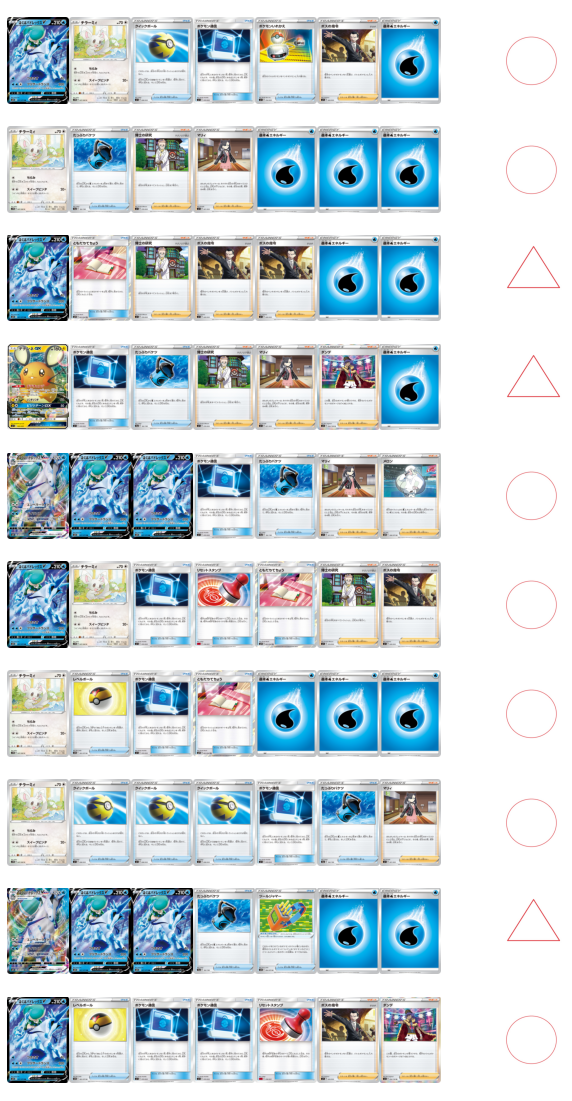

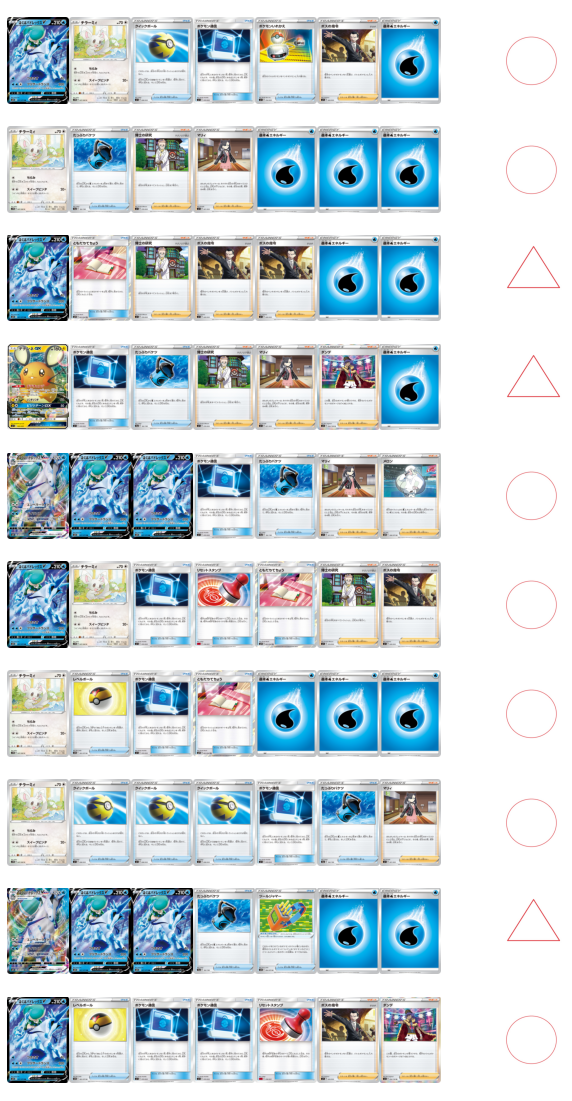

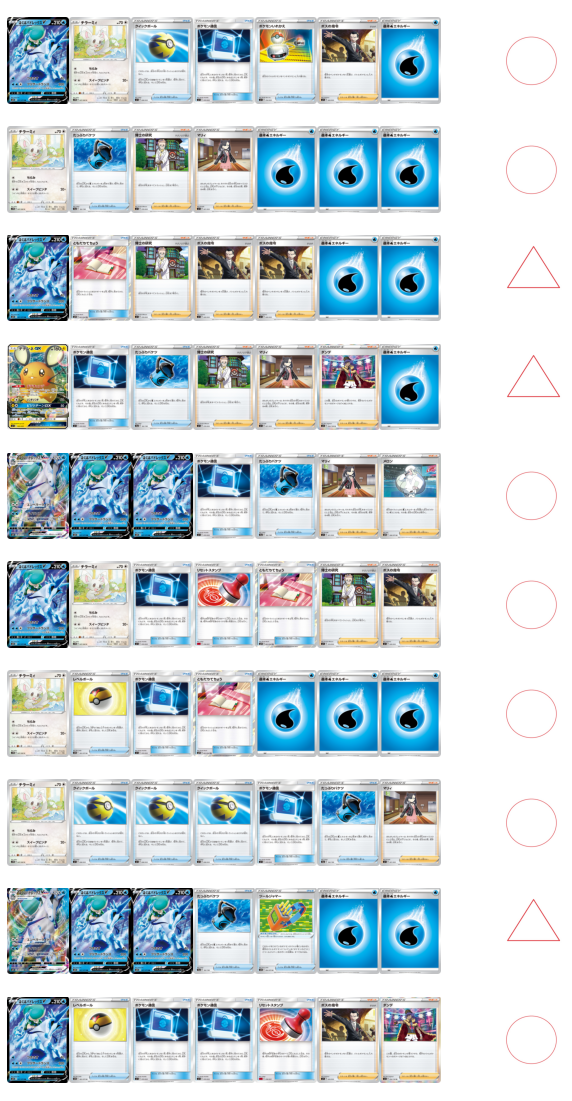

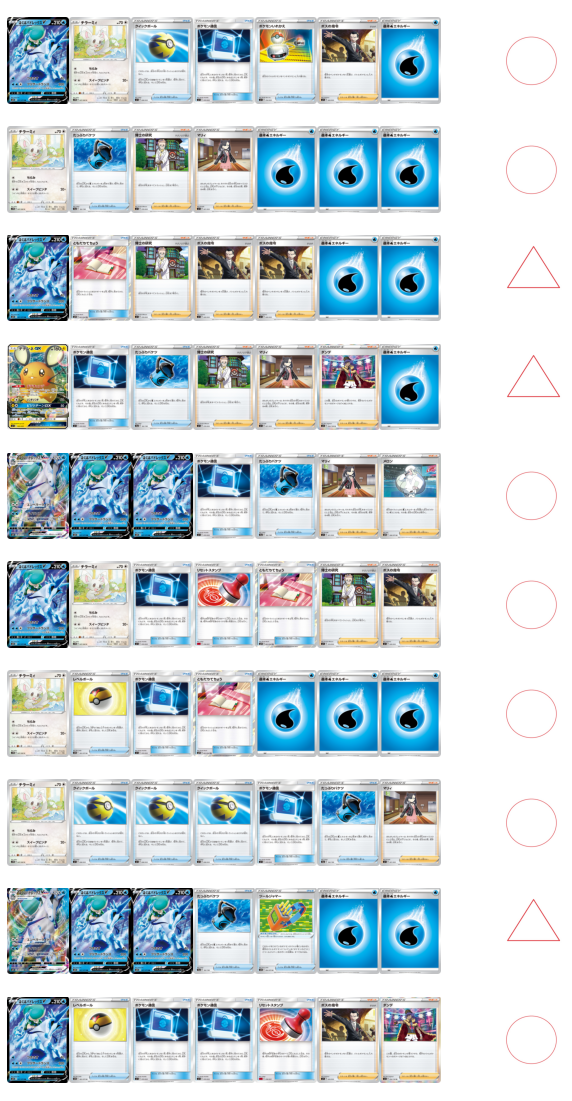

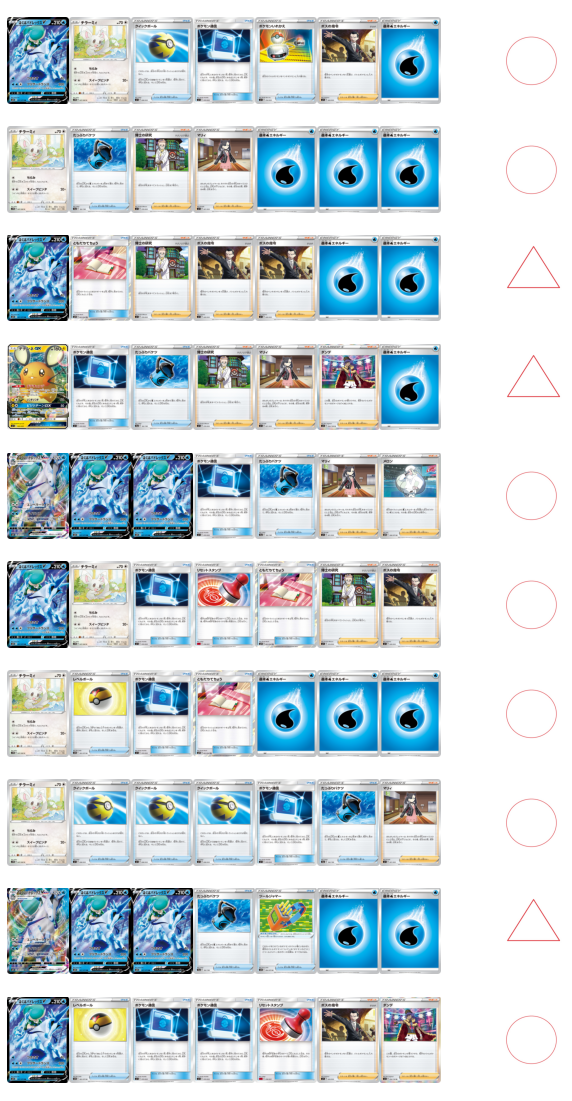

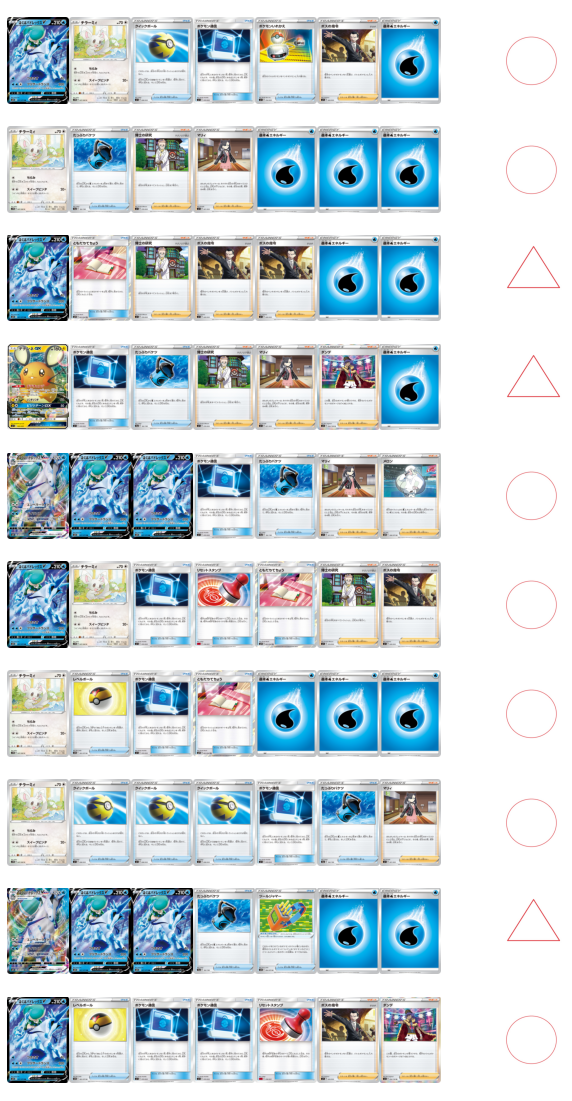

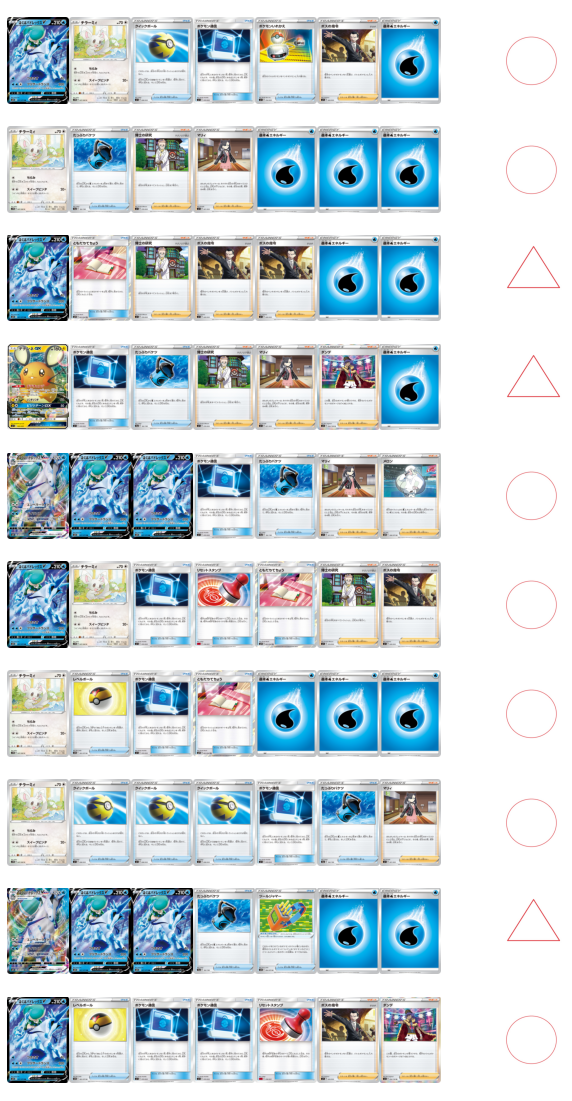

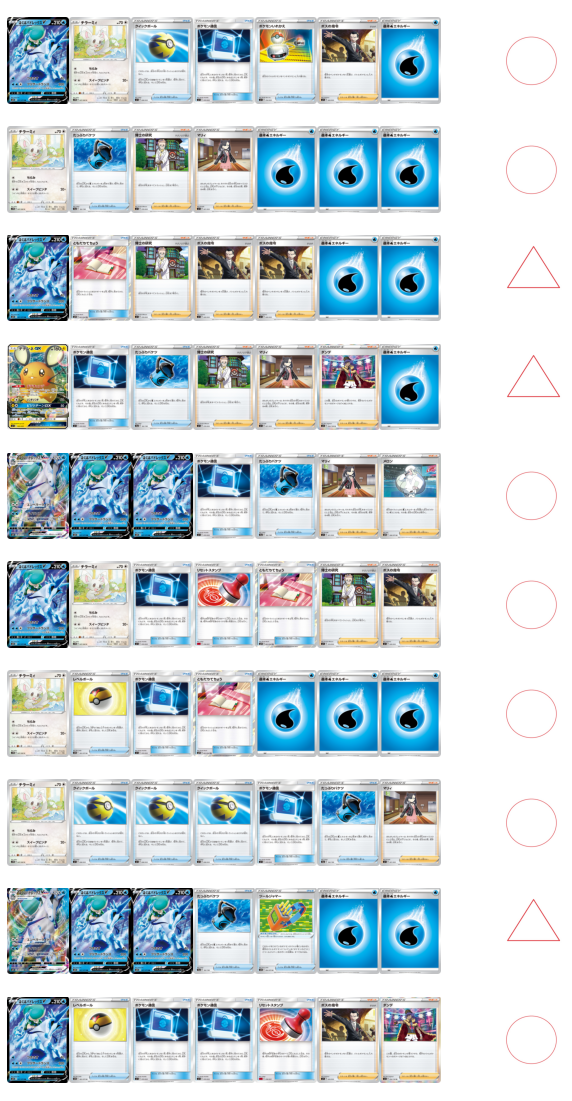

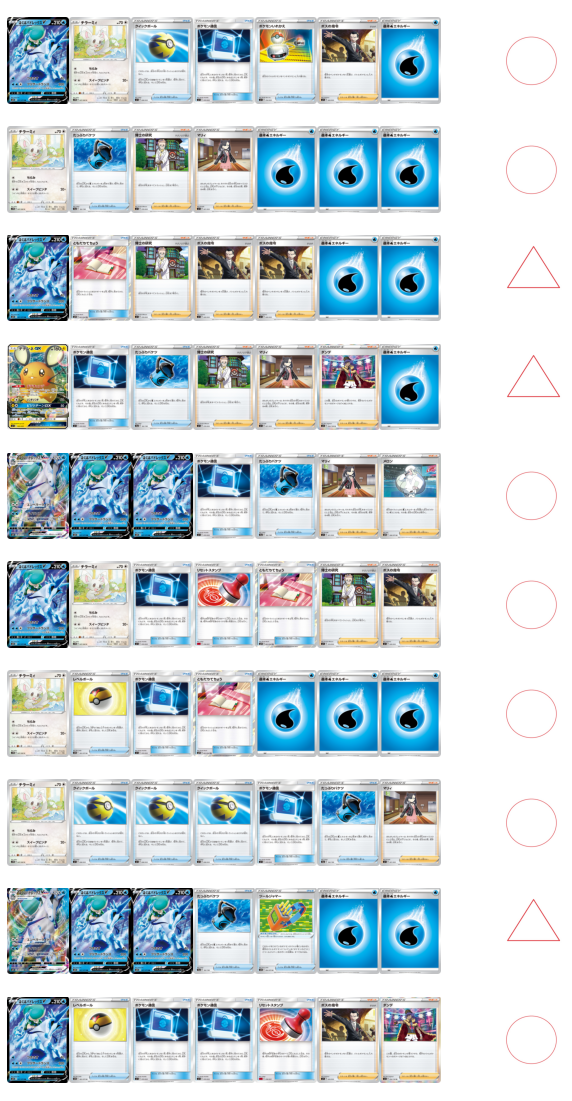

In [17]:
for j in range(1,10):
  imgname= workdir + "/hands_result" +str(j)
  plt.figure(figsize=(10, 20))
  plt.subplots_adjust(wspace=0.0, hspace=0.0)
  print(imgname+ '.jpg')
  for i in range(1,91):
    plt.subplot(10,9,i)
    plt.subplots_adjust(hspace=0.01,wspace=-0)
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")
    plt.tick_params(bottom="off")
    plt.tick_params(left="off")
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.rcParams["font.size"] = 20
    plt.axis("off")
    plt.imshow(image[i]) 
  plt.savefig(imgname + '.jpg')